# Notebook n. 1:

This is a first walk-through some of the functionalities of pyRTX. 
In this example we will show how to set up the code to compute the
Solar Radiation Pressure (SRP) considering the 3D shape of the spacecraft
and different levels of complexity for the sun photons modeling. 

Details about the spacecraft shape modeling are treated in a different notebook

In [1]:
# Imports
import spiceypy as sp
import xarray as xr
import matplotlib.pyplot as plt
import logging, timeit
import numpy as np

from pyRTX.classes.Spacecraft import Spacecraft
from pyRTX.classes.Planet import Planet
from pyRTX.classes.PixelPlane import PixelPlane
from pyRTX.classes.RayTracer import RayTracer
from pyRTX.classes.SRP import SunShadow, SolarPressure 
from pyRTX.classes.Precompute import Precompute
from pyRTX.core.analysis_utils import epochRange2
from pyRTX.visual.utils import plot_mesh
import logging

from numpy import floor, mod

import warnings
warnings.filterwarnings('ignore')

# Managing Error messages from trimesh
# (when concatenating textures, in this case, withouth .mtl definition, trimesh returns a warning that
#  would fill the stdout. Deactivate it for a clean output)
log = logging.getLogger('trimesh')
log.disabled = True

In [2]:
# For all calculations requiring geometry/astrodynamic data we use SPICE
# Thus a metakernel containing attitude/trajectory information must be provided
# See the one provided in the example_data for an example
METAKR = '../example_data/LRO/metakernel_lro.tm'     # metakernel
sp.furnsh(METAKR)  # Load the metakernel containing references to the necessary SPICE frames

In [3]:
# Here we define some general inputs needed by subsequent calculations

# Define the time span of the calculation
ref_epc = "2010 may 10 09:25:00"  # Start epoch of the computation
duration = 10000     # Time span (seconds)
timestep = 100      # Time step (seconds)

epc_et0 = sp.str2et(ref_epc) 
epc_et1 = epc_et0 + duration
epochs = epochRange2(startEpoch=epc_et0, endEpoch=epc_et1, step=timestep)  # This is a utility function to create equally spaed epoche

# Ray tracing options
spacing = 0.01      # Spacing between rays (meters)

# We use the 3D shape of the spacecraft, thus the 3D files must be provided
# Here we always use .obj fles, but other formats can be used
# (as long as they're readable by trimesh)
obj_path = '../example_data/LRO/'

# Some physical constants
base_flux = 1361.5   # Sun flux in W/m2
ref_radius = 1737.4  # Reference radius of the Moon for eclipse calculations
n_cores = 10         # number of cores for parallel calculations




### Spacecraft shape definition
Here we show how to define the spacecraft shape

In [4]:
# The spacecraft mass can be a float, int or a xarray with times and values [kg]
# Here we use the simple case of a constant mass. See other examples for more details
# on using a time-variable mass
sc_mass = 2000  # kg


# 3D shape definition

# Define the Spacecraft Object 
# The spacecraft object is basically a dictionary
# containing each component of the spacecraft. 
# Each component must have a 3d shape,  a reference frame,
# a position and thermo-optical coeffiients (diffusive and specular)
# 
# The reference frame of each object can be defined as the name
# of a spice frame (frame_type = 'Spice') thus CK kernels must be provided
# or as a User Defined frame (frame_type = 'UD'). In this case the user must provide the 
# rotation matrix between the object frame and the base frame of the overall spaecraft.
# Here we use the Spice frames defined for LRO. In another example we'll see how to 
# use custom frames to achieve different results. 


#(Refer to the class documentation for further details)

lro = Spacecraft( name = 'LRO',
                 
				  base_frame = 'LRO_SC_BUS', 					     # Name of the spacecraft body-fixed frame
      
                  mass = sc_mass,
      
				  spacecraft_model = {						         # Define a spacecraft model
                          
					'LRO_BUS': { 
							 'file' : obj_path + 'bus_rotated.obj',	 # .obj file of the spacecraft component
							 'frame_type': 'Spice',				     # type of frame (can be 'Spice' or 'UD')
							 'frame_name': 'LRO_SC_BUS',			 # Name of the frame
							 'center': [0.0,0.0,0.0],			     # Origin of the component in the S/C frame
							 'diffuse': 0.1,				         # Diffuse reflect. coefficient
							 'specular': 0.3,				         # Specular reflect. coefficient
							 },

					'LRO_SA': {	
							'file': obj_path + 'SA_recentred.obj',
							'frame_type': 'Spice',
							'frame_name': 'LRO_SA',
							'center': [-1,-1.1, -0.1],
							'diffuse': 0,
							'specular': 0.3,
							},


					'LRO_HGA': { 	
							'file': obj_path + 'HGA_recentred.obj',
							'frame_type': 'Spice',
							'frame_name': 'LRO_HGA',
							'center':[-0.99,    -0.3,  -3.1],
							'diffuse': 0.2,
							'specular': 0.1,
							},
					}
				)


Spacecraft LRO composed of 3 elements: 
1) LRO_BUS: Proper Frame: LRO_SC_BUS | Frame Type: Spice 
2) LRO_SA: Proper Frame: LRO_SA | Frame Type: Spice 
3) LRO_HGA: Proper Frame: LRO_HGA | Frame Type: Spice 



(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'LRO'}, xlabel='X', ylabel='Y', zlabel='Z'>)

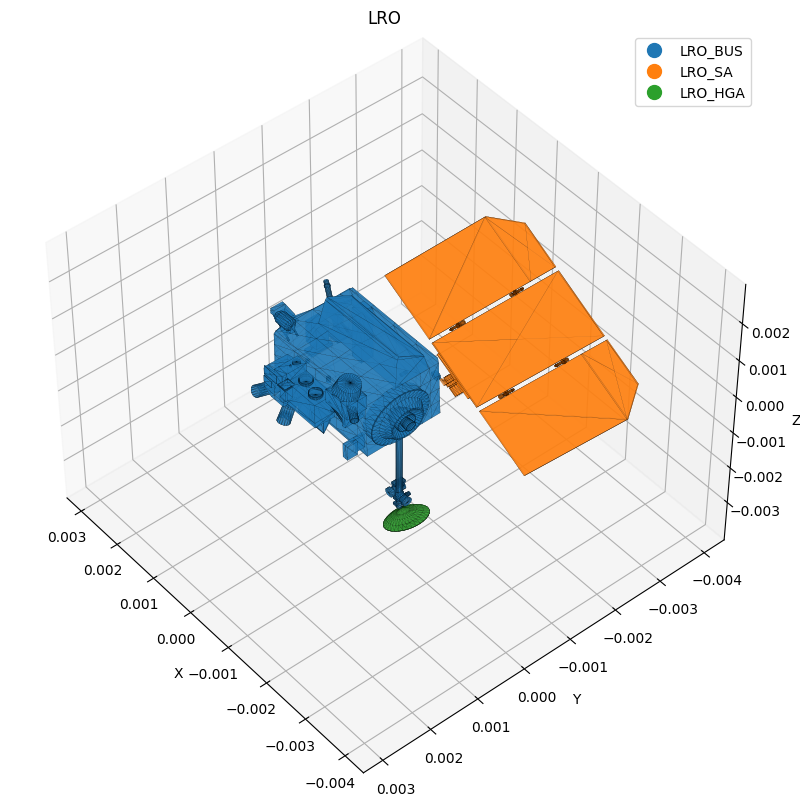

In [5]:
# Let's visualize the spacecraft to make sure everything is set up properly
lro.info() # Print information about the spaceraft shape components
# Get the mesh of the whole spacecraft at a certain time
# The split option allows to retrieve the separate meshes for each component
mesh = lro.dump(epc_et0, split = True)
mesh_names = lro.spacecraft_model.keys()

# Use the visualization utility
plot_mesh(mesh, 
          title = 'LRO',
          labels = list(mesh_names),
          elev = 45, azim = 140 # These are the angles of the viewpoint
         )


To compute the SRP we need also to define 
1) The source body (Sun)
2) The solar pressure object




3) The eclipse body (the Moon in the case of LRO)
4) The ray tracer
5) The shadow model, which describes how the shadow is accounted for


In [6]:
# In pyRTX for most uses, the Sun is modeled as a rectangular
# "pixel plane". This is substantially a source plane for all 
# the rays that will be tracked (traced). 

# Define the Sun rays object
rays = PixelPlane( spacecraft  = lro,         # Spacecraft object 
			       mode        = 'Dynamic',   # Mode: can be 'Dynamic' ( The sun orientation is computed from the kernels), or 'Fixed'
			       distance    = 100,	      # Distance of the ray origin from the spacecraft (in meters)
			       source      = 'Sun',       # Source body (used to compute the orientation of the rays wrt. spacecraft)
			       width       = 10,	      # Width of the pixel plane (in m)
			       height      = 10,          # Height of the pixel plane (in m)
			       ray_spacing = spacing,     # Ray spacing (in m)
				   )


# Define the ray tracer
rtx = RayTracer( lro,                    # Spacecraft object
                 rays,                   # pixelPlane object
                 kernel = 'Embree3',     # The RTX kernel to use (can be either Embree or Embree 3)
                 bounces = 1,            # The number of bounces to account for
                 diffusion = False,      # Account for secondary diffusion
                ) 



# Define the solar pressure object
srp = SolarPressure( lro, 
				     rtx,
				     baseflux       = base_flux,    # Here we use the None option to obtain the generalized geometry vector, used also for the computation of albedo and thermal infrared
				     shadowObj      = None,

				     )
# Compute the SRP acceleration 
# Note the default output of srp.compute is in km/s2
accel = srp.compute(epochs, n_cores = 1) * 1e3

Text(0.5, 0, 'Hours from t0')

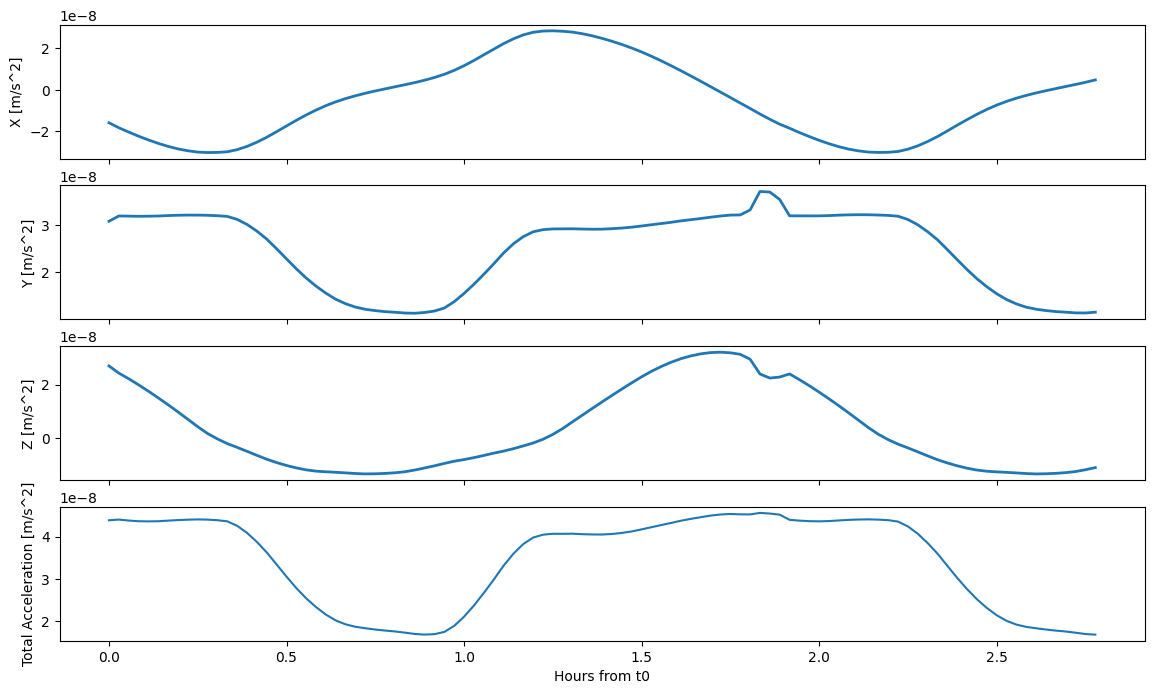

In [7]:
# Let's plot the results
eps  = [float( epc - epc_et0)/3600 for epc in epochs]

fig, ax = plt.subplots(4, 1, figsize=(14,8), sharex = True)

ax[0].plot(eps, accel[:,0], linewidth = 2, color = "tab:blue")
ax[0].set_ylabel('X [m/s^2]')
ax[1].plot(eps, accel[:,1], linewidth = 2, color = "tab:blue")
ax[1].set_ylabel('Y [m/s^2]')
ax[2].plot(eps, accel[:,2], linewidth = 2, color = "tab:blue")
ax[2].set_ylabel('Z [m/s^2]')
ax[3].plot(eps, np.linalg.norm(accel, axis = 1))
ax[3].set_ylabel('Total Acceleration [m/s^2]')
ax[3].set_xlabel('Hours from t0')

## Understanding the importance of the attitude
This was the acceleration just due to the solar radiation pressure, without taking into account eclipses, special shadow models, etc. So then, why does it change so much in less than an hour? 
Remember LRO is orbiting around the Moon, and its attitude with respect to the Sun is changing. 
Let's try to visualize this. 
Let's grab four epochs and visualize the spacecraft from the sun direction. 

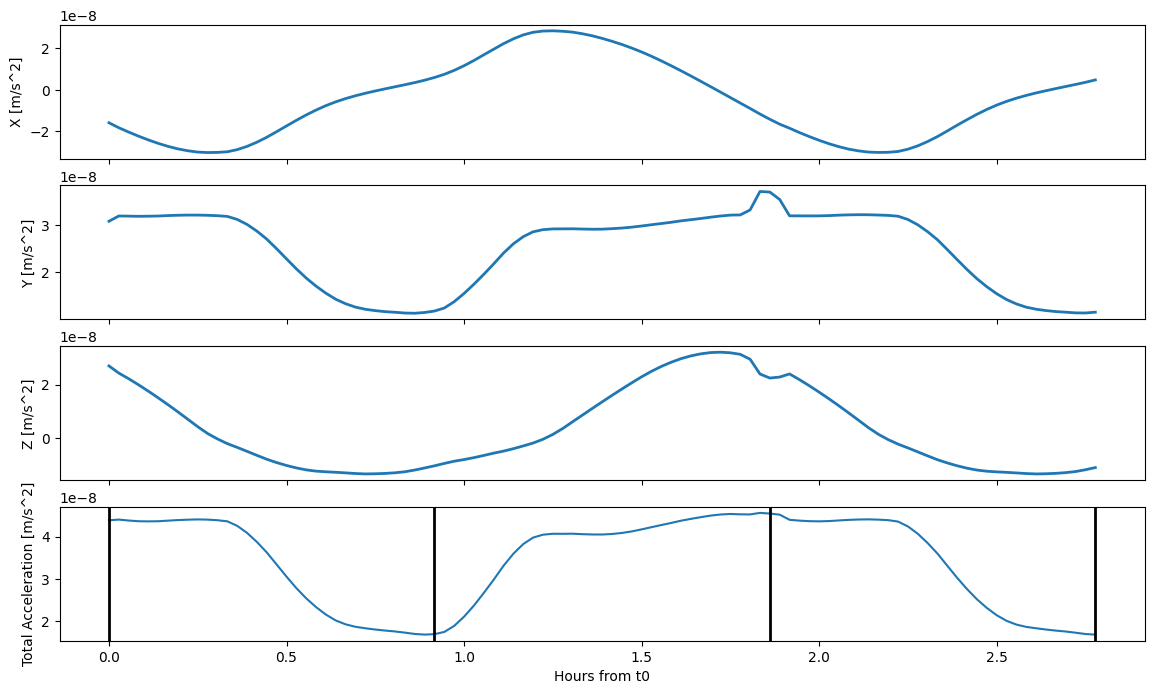

In [8]:
# Get four epochs from tspan
n_epochs = [ epochs[0], epochs[len(epochs)//3], epochs[2*len(epochs)//3], epochs[-1]]
# Quickly plot them onto the previous plot just to make sure they're corret
for e in n_epochs:
    ax[3].axvline(float( e - epc_et0)/3600, color = 'k', linewidth = 2)
display(fig)

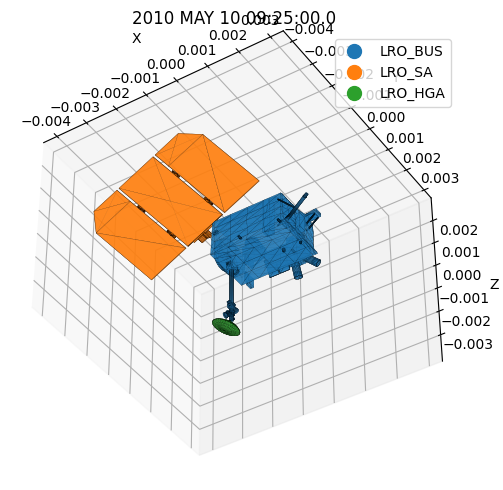

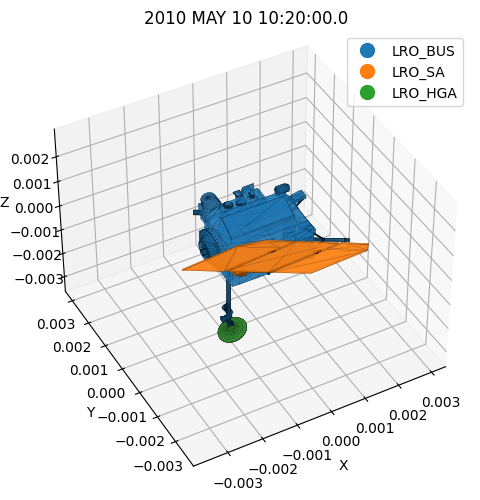

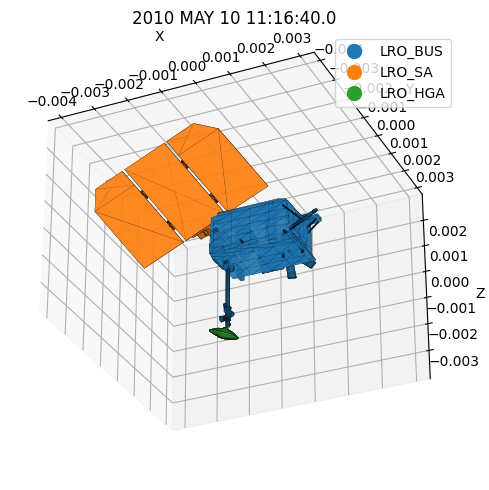

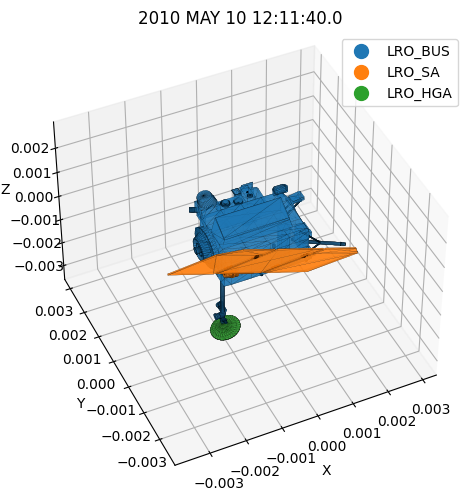

In [9]:
# Let's get the Sun's diretion in the spacecraft frame at those epochs:
# and look at the spacecraft shape from the Sun's viewpoint

unit_vectors = []
directions = []
for ep in n_epochs:
    sunPos = sp.spkezr('Sun', ep, 'LRO_SC_BUS', 'LT+S', 'LRO')[0][0:3]
    unit_vector =  sunPos/np.linalg.norm(sunPos) 
    _, ra, dec = sp.recrad(unit_vector)
    directions.append([ra*180/np.pi,dec*180/np.pi])

    
# Now plot the four attitudes
start_point = [0, 0, 0] # Origin of the sun direction arrow
for i in range(len(n_epochs)):
    mesh = lro.dump(n_epochs[i], split = True)
    # Plot the spacecraft
    fig, ax = plot_mesh(mesh, 
              title = sp.et2utc(n_epochs[i], 'C', 1),
              figsize = (5,5), 
              labels = list(mesh_names),
              elev = directions[i][1], azim = directions[i][0] # These are the angles of the viewpoint
   
                    )
    # This is to add the direction of the sun as an arrow.
    # Add the arrow
    # direction = unit_vectors[i]
    # ax.quiver(start_point[0], start_point[1], start_point[2],
    #       direction[0], direction[1], direction[2],
    #       color='red', arrow_length_ratio=0.2, linewidth=2)

    

## Adding the eclipses and shadow
In the previous example we could clearly see the influence of the changing relative attitude between the spaceraft and the Sun, as expected. 
Now we can add additional effects: Let's take into account the Moon, as a shadowing body.

Notice here how the spacecraft enters eclipse, thus the total acceleration is 0 during certain periods

Text(0.5, 0, 'Hours from t0')

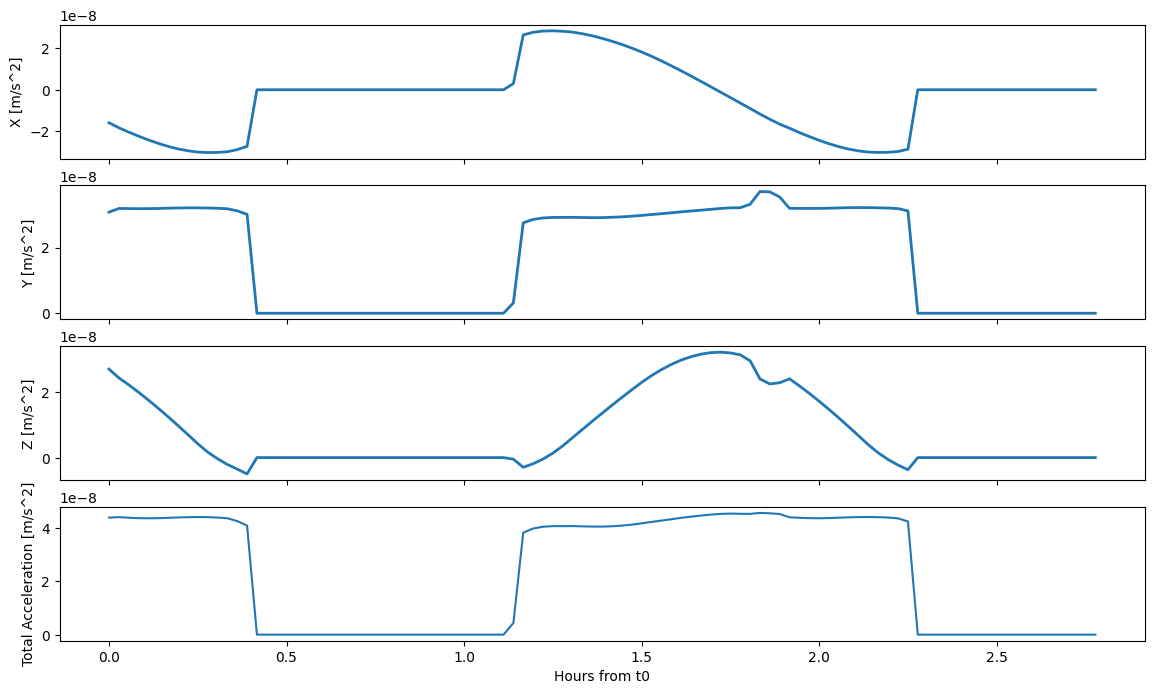

In [11]:
# Define the Moon object
# This can be defined as a sphere with a set radius
# or its shape can be loaded from an .obj 3D file.
#
moon = Planet(  fromFile      = None, # If None a sphere will be used
                radius        = ref_radius, # This is the radius of the sphere
                name          = 'Moon', 
                bodyFrame     = 'MOON_ME', # Moon body-fixed frame
                sunFixedFrame = 'GSE_MOON', # Sun-fixed frame (more details in the albedo example)
                units         = 'km',
                subdivs       = 5, # How detailed the sphere will be (this is an input to trimesh.creation.icosphere
                )                  # see trimesh documentation for more details)


shadow = SunShadow( spacecraft     = lro,
				    body           = 'Moon',
				    bodyShape      = moon,
				    limbDarkening  = 'Eddington',
        			precomputation = None,
				    )

# Define the solar pressure object
srp = SolarPressure( lro, 
				     rtx,
				     baseflux       = base_flux,   
				     shadowObj      = shadow, # Note the differene here
 
				     )

# Compute the SRP acceleration 
accel = srp.compute(epochs, n_cores = 1) * 1e3
 # Let's plot the results
eps  = [float( epc - epc_et0)/3600 for epc in epochs]

fig, ax = plt.subplots(4, 1, figsize=(14,8), sharex = True)

ax[0].plot(eps, accel[:,0], linewidth = 2, color = "tab:blue")
ax[0].set_ylabel('X [m/s^2]')
ax[1].plot(eps, accel[:,1], linewidth = 2, color = "tab:blue")
ax[1].set_ylabel('Y [m/s^2]')
ax[2].plot(eps, accel[:,2], linewidth = 2, color = "tab:blue")
ax[2].set_ylabel('Z [m/s^2]')
ax[3].plot(eps, np.linalg.norm(accel, axis = 1))
ax[3].set_ylabel('Total Acceleration [m/s^2]')
ax[3].set_xlabel('Hours from t0')


### Speeding up the code
Until now we have run computations on a single core. Indeed it takes quite some time to 
compute the acceleration. 

Let's use some smart parallelization and see how much we can speed it up

In [12]:
# First let's time the normal execution
tic = timeit.default_timer()
accel = srp.compute(epochs, n_cores = 1) * 1e3
toc = timeit.default_timer()
print('Time for single-core execution: {} sec'.format(toc-tic))


# Let's now use the parallelization

# Precomputation object. This object performs all the calls to spiceypy before 
# calculating the acceleration. This is necessary when calculating the acceleration
# with parallel cores.
prec = Precompute(epochs = epochs,)
prec.precomputeSolarPressure(lro, moon, correction='LT+S')
prec.dump()

shadow = SunShadow( spacecraft     = lro,
				    body           = 'Moon',
				    bodyShape      = moon,
				    limbDarkening  = 'Eddington',
        			precomputation = prec, # Note the difference here
				    )

# Define the solar pressure object
srp = SolarPressure( lro, 
				     rtx,
				     baseflux       = base_flux,   
				     shadowObj      = shadow, 
                     precomputation = prec, # Note the difference here
				     )

N_cores = 5
tic = timeit.default_timer()
accel = srp.compute(epochs, n_cores = N_cores) * 1e3
toc = timeit.default_timer()
print('Time for multi-core execution (N cores {}): {} sec'.format(N_cores, toc-tic))


N_cores = 10
tic = timeit.default_timer()
accel = srp.compute(epochs, n_cores = N_cores) * 1e3
toc = timeit.default_timer()
print('Time for multi-core execution (N cores {}): {} sec'.format(N_cores, toc-tic))

Time for single-core execution: 36.084838122013025 sec
Time for multi-core execution (N cores 5): 16.167003075010143 sec
Time for multi-core execution (N cores 10): 15.889135109027848 sec


### Exporting the data
Once the accelerations have been computed, the user can choose to use them in any OD/GNC code. 
We provide a few export utilities to simplify some common operations:

1) `export_formatted()`
   exports the accelerations as a csv file
2) `export_exac()`
   exports the acceleration in the GEODYN external acceleration (EXAC) binary interchange format

In [12]:
from pyRTX.utilities import export_formatted

output_file = 'outputs/exported_acceleration.csv'
# The unit input is optional. If provided it will print the units
# of the acceleration in the output file header
export_formatted(accel, epochs,  output_file, units = 'km/s2')

In [13]:
from pyRTX.utilities import export_exac, to_datetime

# This format requires more inputs
# See the function documentation for more information. 
outfile = 'outputs/exported_accelerations.ex'
satelliteID = '075'
data = accel
tstep = timestep
startTime = to_datetime(epochs[0])
endTime = to_datetime(epochs[-1])


export_exac(satelliteID, data, tstep, startTime, endTime, outfile)
